# 基于HDDM拟合2back任务

## 1.加载packages

In [1]:
import sys

print("Python 版本:", sys.version)

Python 版本: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21) 
[GCC 10.3.0]


In [2]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## 2.导入数据集

In [3]:
! pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 884.4 kB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import hddm
import matplotlib.pyplot as plt
import seaborn as sns

# 读取 Excel 文件
file_path = './rawdata.xlsx'
trial_data = pd.read_excel(file_path)

# 清理列名中的空格
trial_data.columns = trial_data.columns.str.strip()

# 确保反应时间列 'rt' 被转换为浮点数类型
trial_data['rt'] = pd.to_numeric(trial_data['rt'], errors='coerce')

# 确保 'Group' 列的数据类型为字符串，并去除可能的空格
trial_data['Group'] = trial_data['Group'].astype(str).str.strip()

# 检查数据
print(trial_data.tail())
print(f"The number of trials: {trial_data.shape[0]}")
print(f"The number of variables: {trial_data.shape[1]}")
print(f"The number of participants: {trial_data['subj_idx'].unique().shape[0]}")

# 重新命名必要的列，确保与 HDDM 的要求一致
data = hddm.utils.flip_errors(trial_data)

# 数据检查完成，准备后续模型的构建

          ID  subj_idx  response     rt Group
16296  16363       272         1  0.123     1
16297  16364       272         1  0.172     1
16298  16365       272         0  0.027     1
16299  16366       272         0  0.023     1
16300  16367       272         0  0.143     1
The number of trials: 16301
The number of variables: 5
The number of participants: 211


In [5]:
data=trial_data

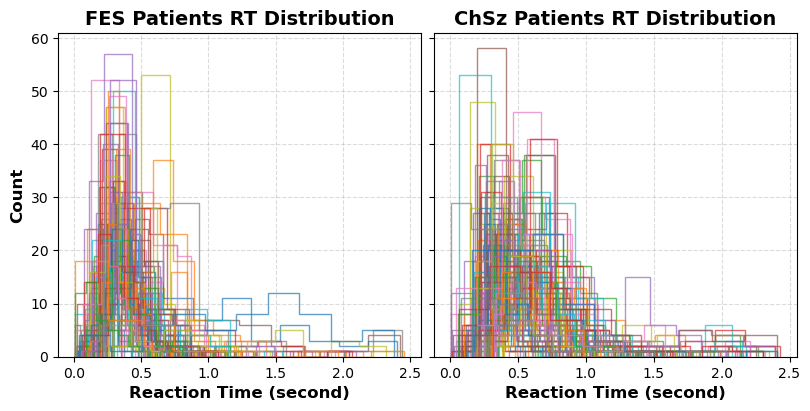

In [6]:
import matplotlib.pyplot as plt

# 分组标签映射（字符串类型）
group_labels = {
    '1': 'FES Patients',
    '2': 'ChSz Patients'
}

# 确保组的顺序为 ['1', '2']
groups = ['1', '2']

# 创建子图
fig, axs = plt.subplots(1, len(groups), figsize=(8, 4), sharey=True, constrained_layout=True)

for idx, group in enumerate(groups):
    group_data = data[data['Group'] == group]
    ax = axs[idx]  # 当前子图
    ax.set_title(f"{group_labels[group]} RT Distribution", fontsize=14, weight='bold')
    
    # 绘制每个 subj_idx 的反应时间分布
    for subj_idx, subj_data in group_data.groupby('subj_idx'):
        subj_data.rt.hist(bins=10, histtype='step', ax=ax, alpha=0.7)
    
    ax.set_xlabel('Reaction Time (second)', fontsize=12, weight='bold')
    if idx == 0:  # 仅在第一个子图中设置 Y 轴标签
        ax.set_ylabel('Count', fontsize=12, weight='bold')
    
    # 添加网格线
    ax.grid(axis='both', linestyle='--', alpha=0.45)  # 设置网格线为虚线，透明度为 0.7

# 保存图像
plt.savefig('rt_distributions_by_group_with_grid.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [7]:
# 检查 Group 列的唯一值及其数据类型
print(data['Group'].unique())
print(data['Group'].dtype)

# 确保 Group 列的值为字符串类型，并移除可能存在的空格
data['Group'] = data['Group'].astype(str).str.strip()

# 再次计算 Group 1 和 Group 2 中的唯一被试数量
unique_group1_subjects = data[data['Group'] == '1']['subj_idx'].nunique()
unique_group2_subjects = data[data['Group'] == '2']['subj_idx'].nunique()

print(f"First episode of schizophrenia = {unique_group1_subjects}")
print(f"Chronic schizophrenia = {unique_group2_subjects}")

['2' '1']
object
First episode of schizophrenia = 103
Chronic schizophrenia = 108


#### 1.模型设计

In [8]:
import hddm

# 打印数据的类型，确保数据格式正确
# 数据应为一个 Pandas DataFrame，包含反应时间（RT）、正确性（accuracy）以及组别等列
print(f"Data type: {type(data)}")

# 基础模型（m0）：包含所有核心参数和变异性参数
# 该模型不考虑条件或组别，只用于全局参数估计
m0 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'sz', 'st']  # 包含所有参数和变异性参数
)

# 综合模型（m2）：分层模型，探索所有组别间参数的变化
# 假设核心参数（a, v, t, z）依赖于组别（Group）
m1 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],  # 包含所有核心参数和变异性参数
    depends_on={  # 假设参数依赖于组别
        'a': ['Group'], 
        'v': ['Group'], 
        't': ['Group'],
        'z': ['Group']
    }
)


# 回归模型（m3v）：分析组别对漂移率（v）的影响
m2v = hddm.HDDMRegressor(
    data,
    "v ~ 1 + C(Group, Treatment('2'))",  # 漂移率 v 的回归公式，Group 为分组变量，'2' 为参考组
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],  # 包含所有核心参数和变异性参数
    group_only_regressors=False,  # 允许个体层面的变化
    keep_regressor_trace=True  # 保留回归系数的 MCMC 采样轨迹
)

# 回归模型（m3z）：分析组别对起始点偏移（z）的影响
m2z = hddm.HDDMRegressor(
    data,
    "z ~ 1 + C(Group, Treatment('2'))",  # 起始点 z 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 回归模型（m3a）：分析组别对决策界限（a）的影响
m2a = hddm.HDDMRegressor(
    data,
    "a ~ 1 + C(Group, Treatment('2'))",  # 决策界限 a 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 回归模型（m3t）：分析组别对非决策时间（t）的影响
m2t = hddm.HDDMRegressor(
    data,
    "t ~ 1 + C(Group, Treatment('2'))",  # 非决策时间 t 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

# 打印模型初始化完成的信息
print('模型已成功初始化！😄')

Data type: <class 'pandas.core.frame.DataFrame'>
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
模型已成功初始化！😄


#### 2.模型拟合参数量 

In [9]:
def run_sampling(
    m,
    n_samples=10000,  # 10,000
    n_burn=5000,     # 5000
    n_chains=4,      # 4
    thin=2,  # Thinning：每隔2个样本保留1个
    model_name="m",
    progress_bar=True
):
    m_infdata = m.sample(
        n_samples,
        burn=n_burn,
        chains=n_chains,
        return_infdata=True,
        save_name="8.model_fitted/" + model_name,
        progress_bar=progress_bar
    )

    return m, m_infdata


# 计算时间估计
print('拟合参数设置成功!')

拟合参数设置成功!


**注：在配备 2.90GHz 英特尔®酷睿™i7-10700 处理器的电脑上，用上述设置（10000 个样本）拟合所有这六个模型大约需要 8-9 个小时。此外，内存应足够大，建议使用 ~ 64 G 内存。否则，建议使用少量样本（如 n_samples=2500，burn=1000）。

#### 3.读取之前好的模型😂

In [10]:
import pickle

# 模型和推断数据的文件名
model_names = ["m0","m1"] 
 
# 创建字典存储模型和推断数据
models = {}
infdata = {}

# 加载所有模型和推断数据
for name in model_names:
    model_file_path = f'./2.模型拟合-输出/{name}_model.pkl'
    infdata_file_path = f'./2.模型拟合-输出/{name}_infdata.pkl'
    
    # 重新加载模型
    with open(model_file_path, 'rb') as f_model:
        models[name] = pickle.load(f_model)
    
    # 重新加载推断数据
    with open(infdata_file_path, 'rb') as f_infdata:
        infdata[name] = pickle.load(f_infdata)
    
    # 动态赋值回原始变量名
    globals()[name] = models[name]
    globals()[f"{name}_infdata"] = infdata[name]
    
    print(f"{name} 已经成功挂载!")

# 打印已加载的模型和推断数据
for name in model_names:
    print(f"{name} 模型:", globals()[name])
    print(f"{name} 推断数据:", globals()[f"{name}_infdata"])

print('所有模型和推断数据读取成功!😂')

m0 已经成功挂载!
m1 已经成功挂载!
m0 模型: <hddm.models.hddm_info.HDDM object at 0x7f49e1973880>
m0 推断数据: Inference data with groups:
	> posterior
	> observed_data
m1 模型: <hddm.models.hddm_info.HDDM object at 0x7f49e9e0ed00>
m1 推断数据: Inference data with groups:
	> posterior
	> observed_data
所有模型和推断数据读取成功!😂


In [11]:
import pickle

# 定义模型名称列表
model_names = ["m0","m1"]
posterior_distributions = {}

# 循环加载每个模型并提取后验分布
for model_name in model_names:
    print(f"提取 {model_name} 的后验分布...")
    
    # 加载模型
    with open(f'./2.模型拟合-输出/{model_name}_model.pkl', 'rb') as f_model:
        model_loaded = pickle.load(f_model)
    
    # 提取后验分布
    posterior_samples = model_loaded.get_traces()
    
    # 将每个模型的后验分布存储在字典中
    posterior_distributions[model_name] = posterior_samples
    
    # 打印提取的后验分布的前几行
    print(f"{model_name}的后验分布提取完成:")

print("所有模型的后验分布提取完成！😂")


#得20分钟

提取 m0 的后验分布...
m0的后验分布提取完成:
提取 m1 的后验分布...
m1的后验分布提取完成:
所有模型的后验分布提取完成！😂


#### 4.查看内存

In [12]:
import psutil
print(f"Available memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Available memory: 180.54 GB


## 4. 模型比较与选择 (基于DIC)

In [ ]:
! pip3 install tabulate

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 模拟DIC数据，使用模型的具体名称
dic_dict = {
    "Model 1": m0.dic,
    "Model 0": m1.dic,
}

# 将字典转换为Pandas DataFrame,并按照DIC值升序排序
comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic = comp_dic.sort_values(by=['DIC'], ascending=True)

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

# 设置绘图风格，使用符合Nature风格的简洁主题
sns.set(style="whitegrid", font_scale=1.2)

# 创建颜色映射，颜色越大越深
norm = plt.Normalize(comp_dic['DIC'].min(), comp_dic['DIC'].max())
colors = plt.cm.viridis(norm(comp_dic['DIC']))  # 使用 vivid 色彩映射

# 创建柱状图，将 X 和 Y 轴对调
plt.figure(figsize=(6, 5))
bar_plot = sns.barplot(y='model', x='DIC', data=comp_dic, palette=colors)

# 为柱状图中的每个柱子设置透明度、边框粗细和花纹
for patch in bar_plot.patches:
    patch.set_alpha(0.7)  # 设置透明度为0.7
    patch.set_edgecolor('black')  # 设置边框颜色为黑色
    patch.set_linewidth(0.6)  # 设置边框粗细为0.6
    patch.set_hatch('/')  # 设置花纹，'/'表示斜线

# 在柱子上标注具体数值
for i, patch in enumerate(bar_plot.patches):
    width = patch.get_width()
    bar_plot.text(width + 0.5,  # 数值标签的x坐标稍高于柱子顶部
                  patch.get_y() + patch.get_height() / 2,
                  f'{width:.2f}',  # 显示2位小数
                  ha='left', 
                  va='center', 
                  fontsize=8, 
                  weight='bold')

# 添加图形标题和坐标轴标签
bar_plot.set_ylabel("Model", fontsize=12, weight='bold')
bar_plot.set_xlabel("DIC Value", fontsize=12, weight='bold')

# 调整标签和风格，参考Nature风格
bar_plot.tick_params(axis='both', which='major', labelsize=12)
bar_plot.spines['top'].set_visible(False)
bar_plot.spines['right'].set_visible(False)

# 设置左和底部的边框为黑色，并加粗
bar_plot.spines['left'].set_linewidth(1.5)
bar_plot.spines['left'].set_color('black')  # 改为黑色
bar_plot.spines['bottom'].set_linewidth(2)
bar_plot.spines['bottom'].set_color('black')  # 改为黑色

# 设置网格线的透明度和粗细
bar_plot.grid(True, which='major', axis='x', linestyle='-.', linewidth=0.8, alpha=0.8)  # 现在对x轴应用网格线
bar_plot.grid(True, which='major', axis='y', linestyle='-.', linewidth=0.8, alpha=0.8)

# 调整布局以防止标签被截断
plt.tight_layout()

# 保存图片到指定文件夹，并确保不会截断图像
plt.savefig("4.模型比较-输出/DIC_comparison.jpeg", dpi=600, format='jpeg', bbox_inches='tight')  # 使用bbox_inches='tight'来防止截断

# 显示图形
plt.show()

In [ ]:
# 计算模型间的 DIC 差异
comp_dic['ΔDIC'] = comp_dic['DIC'] - comp_dic['DIC'].min()

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

## 5. Posterior predictive check

In [13]:
%time
m1_infdata = m1.to_infdata(loglike = True, ppc = True, n_ppc = 500, save_name = "model_fitted/m1")
print('m1生成PPC 好了😄!')

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
Start converting to InferenceData...
Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 524.244 seconds
Start generating posterior prediction...
The time of generating PPC took 1450.971 seconds
m1生成PPC 好了😄!


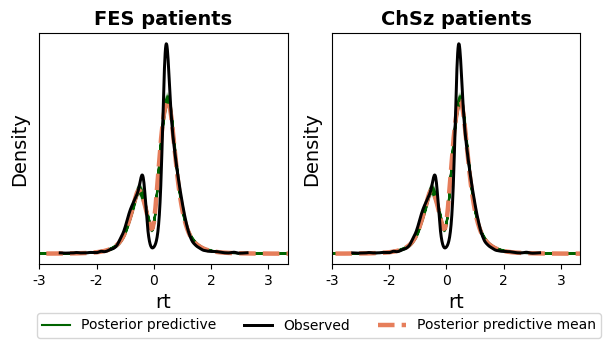

In [115]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(6, 3.5))
# 获取图例句柄和标签
handles, labels = [], []
# 分别绘制两个组的 PPC
group_titles = ['FES patients', 'ChSz patients']

for i, ax in enumerate(axes):
    plot = az.plot_ppc(
        m1_infdata,
        var_names=['rt'],
        num_pp_samples=500,
        random_seed=2024,
        flatten=['obs_id'],
        textsize=20,
        alpha=0.05,  # 降低透明度使后验预测更清晰
        colors=['darkgreen', '#000000', '#E67E5B'],  # 加深黑色以增加对比度
        mean=True,
        group="posterior",
        kind='kde',
        ax=ax,
        legend=False,
        data_pairs={
            "observed_data": {"Group": str(i+1)},
            "posterior_predictive": {"Group": str(i+1)}
        }
    )
    
    ax.set_title(group_titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('rt', fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
    ax.grid(False)
    
    # 设置新的x轴范围和刻度
    ax.set_xlim(-3.0, 3.5)
    xticks = np.arange(-3.0, 3.5, 1.5)
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{x:.0f}' for x in xticks], rotation=0, fontsize=10)
    
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()

# 添加全局图例
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.54, -0.05), ncol=3, fontsize='medium')
# 调整布局
plt.tight_layout(rect=[0, 0, 1, 0.95])
# 保存图像
plt.savefig('./5.PPC检测-输出/PPC-不同组别.jpg', dpi=1200, bbox_inches='tight')
plt.show()


/opt/conda/lib/python3.9/site-packages/arviz/plots/ppcplot.py:241: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


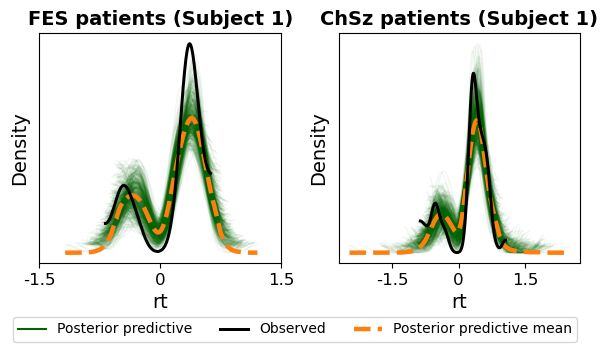

In [105]:
import arviz as az
import matplotlib.pyplot as plt

# 重设坐标
m1_infdata = m1_infdata.assign_coords(
    obs_id=m1_infdata.observed_data.coords['subj_idx'].values,
    groups="observed_vars"
)

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(6, 3.5))  # 1x2布局的子图

# 获取图例句柄和标签
lines = []
labels = []

# 定义观察组的ID和标题
obs_ids = [4, 2]  # 选择不同的 obs_id 作为例子
group_titles = ['FES patients (Subject 1)', 'ChSz patients (Subject 1)']  # 设置标题

# 绘制每个子图
for i, ax in enumerate(axes):
    az.plot_ppc(
        m1_infdata,  # 替换为 m1_infdata
        var_names='rt',
        coords={'obs_id': [obs_ids[i]]},  # 使用当前 obs_id
        num_pp_samples=500,  # 设置后验样本数量
        random_seed=2023,
        flatten=[],
        textsize=20,  # 调整文本大小
        alpha=0.05,    # 设置更低的透明度
        color='darkgreen',  # 设置颜色
        ax=ax,  # 在指定子图中绘制
        kind='kde',  # 使用核密度估计（kde）绘图
    )

    # 设置每个子图的标题和标签
    ax.set_title(group_titles[i], fontsize=14, fontweight='bold')  # 设置标题字体和大小
    ax.set_xlabel('rt', fontsize=14)  # 设置x轴标签
    ax.set_ylabel('Density', fontsize=14)  # 设置y轴标签

    # 隐藏网格线
    ax.grid(False)

    # 自定义x轴刻度和标签
    ax.set_xticks([-1.5, 0, 1.5])  # 设置x轴刻度
    ax.set_xticklabels(['-1.5', '0', '1.5'], fontsize=12)  # 设置x轴刻度标签

    # 获取图例句柄（lines）和标签（labels），只取第一个子图的
    if i == 0:
        handle, label = ax.get_legend_handles_labels()
        lines.extend(handle)
        labels.extend(label)

# 移除子图中的图例
for ax in axes:
    ax.legend().set_visible(False)

# 将全局图例添加到图外
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=10)

# 调整布局，避免重叠
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存高分辨率图像
plt.savefig('./5.PPC检测-输出/单个被试PPC_m1.jpg', dpi=1200, bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.9/site-packages/arviz/plots/ppcplot.py:241: FutureWarning: color has been deprecated in favor of colors
  warnings.warn("color has been deprecated in favor of colors", FutureWarning)


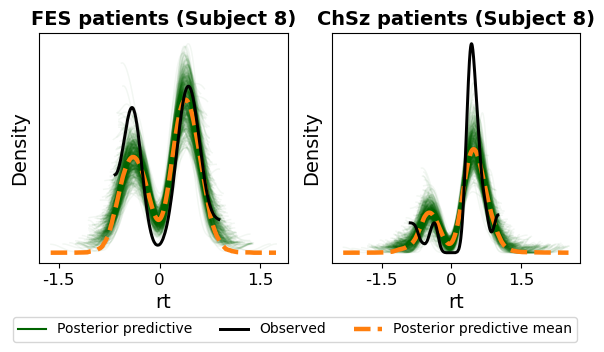

In [119]:
import arviz as az
import matplotlib.pyplot as plt

# 重设坐标
m1_infdata = m1_infdata.assign_coords(
    obs_id=m1_infdata.observed_data.coords['subj_idx'].values,
    groups="observed_vars"
)

# 创建画布
fig, axes = plt.subplots(1, 2, figsize=(6, 3.5))  # 1x2布局的子图

# 获取图例句柄和标签
lines = []
labels = []

# 定义观察组的ID和标题
obs_ids = [20,23]  # 选择不同的 obs_id 作为例子
group_titles = ['FES patients (Subject 8)', 'ChSz patients (Subject 8)']  # 设置标题

# 绘制每个子图
for i, ax in enumerate(axes):
    az.plot_ppc(
        m1_infdata,  # 替换为 m1_infdata
        var_names='rt',
        coords={'obs_id': [obs_ids[i]]},  # 使用当前 obs_id
        num_pp_samples=500,  # 设置后验样本数量
        random_seed=2023,
        flatten=[],
        textsize=20,  # 调整文本大小
        alpha=0.05,    # 设置更低的透明度
        color='darkgreen',  # 设置颜色
        ax=ax,  # 在指定子图中绘制
        kind='kde',  # 使用核密度估计（kde）绘图
    )

    # 设置每个子图的标题和标签
    ax.set_title(group_titles[i], fontsize=14, fontweight='bold')  # 设置标题字体和大小
    ax.set_xlabel('rt', fontsize=14)  # 设置x轴标签
    ax.set_ylabel('Density', fontsize=14)  # 设置y轴标签

    # 隐藏网格线
    ax.grid(False)

    # 自定义x轴刻度和标签
    ax.set_xticks([-1.5, 0, 1.5])  # 设置x轴刻度
    ax.set_xticklabels(['-1.5', '0', '1.5'], fontsize=12)  # 设置x轴刻度标签

    # 获取图例句柄（lines）和标签（labels），只取第一个子图的
    if i == 0:
        handle, label = ax.get_legend_handles_labels()
        lines.extend(handle)
        labels.extend(label)

# 移除子图中的图例
for ax in axes:
    ax.legend().set_visible(False)

# 将全局图例添加到图外
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=10)

# 调整布局，避免重叠
plt.tight_layout(rect=[0, 0, 1, 0.95])

# 保存高分辨率图像
plt.savefig('./5.PPC检测-输出/单个被试PPC_m1-103.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [19]:
print("代码全部完成!")

代码全部完成!
